In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('notebook')

In [2]:
import sys
sys.path.append('../')
import targprop.operations as ops

## define the model 

*(using model notation)*

-----------

$$ h_1 = W_1 x_0\quad\quad x_1 = \operatorname{tanh}(h_1)\quad\quad x_2 = W_2x_1$$

where
$$x_0\in\mathbb{R}^{n_0}, h_1\in\mathbb{R}^{n_1}, x_1\in\mathbb{R}^{n_1}, x_2\in\mathbb{R}^{n_2}$$

In [3]:
# dimensions
n0 = 1 # input dimension / number of input units
n1 = 2 # hidden dimension / number of hidden layer units
n2 = 1  # output dimension

th1 = 3*np.pi/8
W1 = np.array([[np.cos(th1)], [np.sin(th1)]]) # size 2 x 1
th2 = -2*np.pi/8
W2 = np.array([[np.cos(th2) , np.sin(th2)]]) # size 1 x 2

# inputs
num_examples = 21

x0 = np.linspace(-2, 2, num_examples)[np.newaxis, :]

## define operations

In [4]:
lin = ops.linear()
tanh = ops.tanh()

## forward pass on model

In [5]:
# forward pass on the model
h1 = lin.f( W1, x0 )
x1 = tanh.f( h1 )
x2 = lin.f( W2, x1 )

## train model

In [6]:
def train(prop_method, gamma=1, num_steps=10, alpha=0.5):

  W1_est = num_steps*[None]
  h1_est = num_steps*[None]
  x1_est = num_steps*[None]
  x2_est = num_steps*[None]

  loss = num_steps*[None]

  W1_tar = num_steps*[None]
  h1_tar = num_steps*[None]
  x1_tar = num_steps*[None]

  W1_d = num_steps*[None]
  h1_d = num_steps*[None]
  x1_d = num_steps*[None]

  th3 = 1*np.pi/8
  W1_est[0] = np.array([[np.cos(th3)], [np.sin(th3)]])

  for t in range(num_steps):
    # forward:
    h1_est[t] = lin.f( W1_est[t], x0 )
    x1_est[t] = tanh.f( h1_est[t] )
    x2_est[t] = lin.f( W2, x1_est[t] )
    loss[t] = 0.5*np.mean((x2_est[t] - x2)**2)

    # backward:
    if prop_method == 'tp_inv':
      x1_tar[t] = lin.f_inv( x2.T, x1_est[t].T, W2.T ).T
      h1_tar[t] = tanh.f_inv( x1_tar[t], h1_est[t], th=1e-12 )
      W1_tar[t] = lin.f_inv( h1_tar[t], W1_est[t], x0 )
    elif prop_method == 'tp_rinv':
      x1_tar[t] = lin.f_rinv( x2.T, x1_est[t].T, W2.T , gamma=gamma ).T
      h1_tar[t] = tanh.f_rinv( x1_tar[t], h1_est[t], gamma=gamma, scipy_fmin=True )
      W1_tar[t] = lin.f_rinv( h1_tar[t], W1_est[t], x0 )  
    elif prop_method == 'bp':
      # backward derivatives
      x1_d[t] = lin.df( x2_est[t].T - x2.T, h1_est[t].T, W2.T ).T
      h1_d[t] = tanh.df( x1_d[t], h1_est[t] )
      W1_d[t] = lin.df( h1_d[t], W1_est[t], x0 )
      
      x1_tar[t] = x1_est[t] - x1_d[t]
      h1_tar[t] = h1_est[t] - h1_d[t]
      W1_tar[t] = W1_est[t] - W1_d[t]
    elif prop_method == 'tp_then_bp':
      x1_tar[t] = lin.f_rinv( x2.T, x1_est[t].T, W2.T , gamma=gamma ).T
      h1_tar[t] = tanh.f_rinv( x1_tar[t], h1_est[t], gamma=gamma, scipy_fmin=False )
      W1_d[t] = lin.df( h1_est[t] - h1_tar[t], W1_est[t], x0 )
      
      W1_tar[t] = W1_est[t] - W1_d[t]
          
    if t < num_steps - 1:
      W1_est[t+1] = W1_est[t] - alpha*(W1_est[t] - W1_tar[t])
      
  return { 'W1_est':W1_est, 'h1_est':h1_est, 'x1_est':x1_est, 'x2_est':x2_est,
           'loss':loss,
           'W1_tar':W1_tar, 'h1_tar':h1_tar, 'x1_tar':x1_tar,
           'W1_d':W1_d, 'h1_d':h1_d, 'x1_d':x1_d }

In [18]:
num_steps = 50000

datasets = {}
datasets['bp'] = train('bp', num_steps=num_steps, alpha=0.001)
#datasets['tp_inv'] = train('tp_inv', num_steps=num_steps, alpha=1e-4)

for i, gamma in enumerate([1000, 3000, 10000]):
  datasets['rinv_'+str(gamma)] = train('tp_rinv', num_steps=num_steps, gamma=gamma, alpha=1.0)
  datasets['rinv_'+str(gamma)]['idx'] = i
  
#datasets['tp_then_bp'] = train('tp_then_bp', num_steps=num_steps, gamma=1e0, alpha=0.01)

In [19]:
def plot_x2s(data, title=None):
  num_steps = len(data['x2_est'])
  sns.set_palette(sns.color_palette("RdBu", num_steps+1))
  f = plt.plot(x2.T,'ko')[0]
  for t in range(num_steps):
    plt.plot(data['x2_est'][t].T,'o')
  plt.xlim([-1, num_examples+1])
  f.axes.xaxis.set_ticks(np.arange(0, num_examples+1))
  plt.xlabel('examples')
  plt.ylabel('x2')
  plt.title(title)
  plt.show()


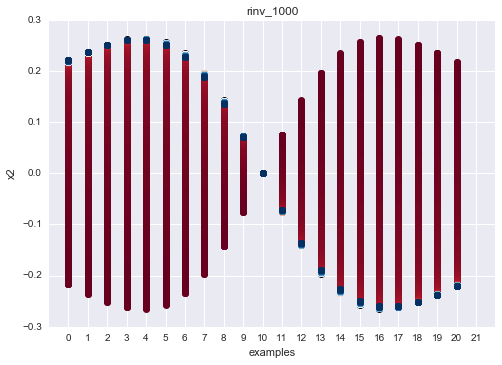

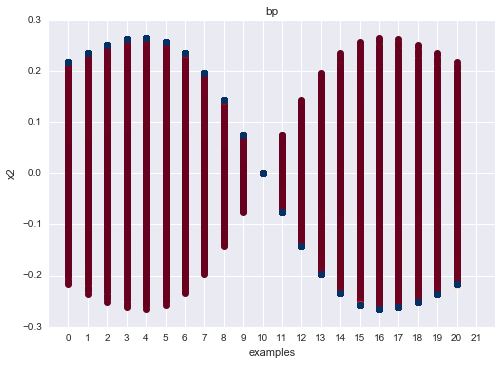

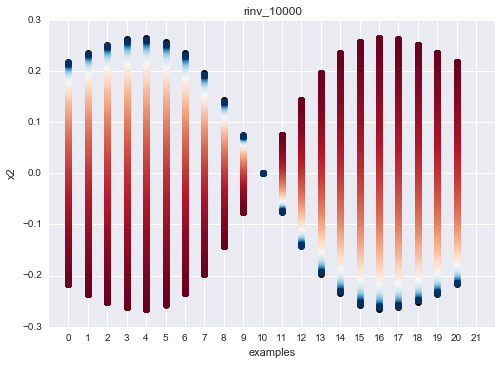

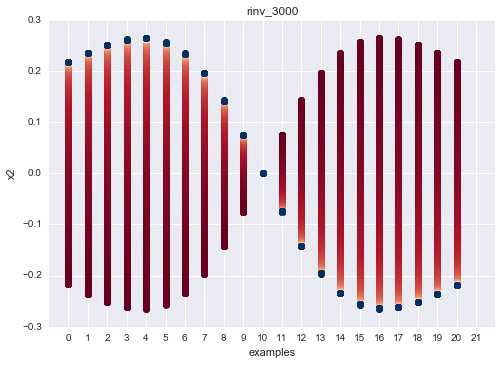

In [20]:
for key, val in datasets.items():
  plot_x2s(val, key)


In [21]:
def plot_loss(data, ax, label):
  ax.plot(np.log(data['loss']), '-', label=label)

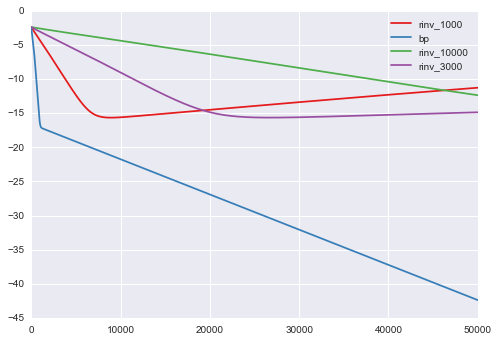

In [22]:
sns.set_palette(sns.color_palette("Set1", 10))

fig = plt.figure()
ax = fig.add_subplot(111)

for key, val in datasets.items():
  plot_loss(val, ax, key)

plt.legend()

In [23]:
# plot W1 loss...
wa, wb = np.meshgrid(np.linspace(-3,3,500), np.linspace(-3,3,500))

In [24]:
l_grid = np.zeros_like(wa)
for i in range(wa.shape[0]):
  for j in range(wa.shape[0]):
    l_grid[i,j] = 0.5*np.mean((np.dot( W2, np.tanh( np.dot( np.array([[wa[i,j]], [wb[i,j]]]), x0 ) ) ) - x2)**2)


In [25]:
def plot_traj(data, ax, c, label=None):
  w1_scatter = np.stack(data['W1_est'])
  ax.plot(w1_scatter[:,0,0], w1_scatter[:,1,0], '-', c=c, label=label)

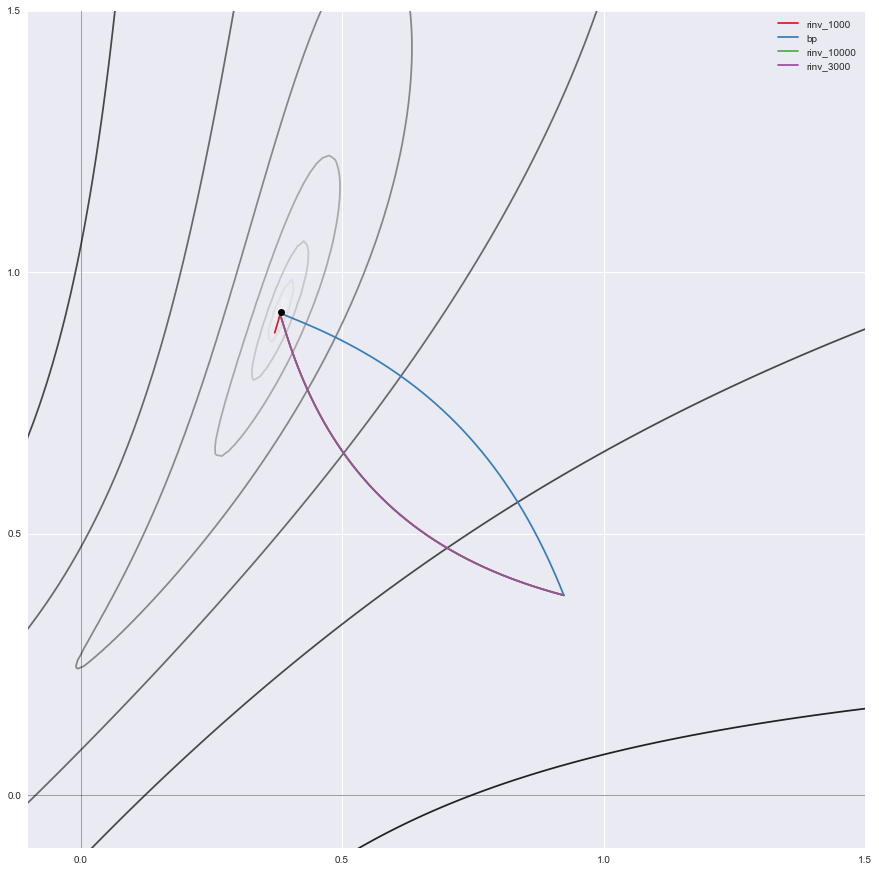

In [26]:
cmap = sns.color_palette('Set1', 100)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

ax.contour(wa, wb, np.log(l_grid), 10)

for i, (key, val) in enumerate(datasets.items()):
  plot_traj(val, ax, cmap[i], key)

ax.plot(W1[0], W1[1],'ko')

axify(ax, [-3, 3])
plt.xlim([-0.1, 1.5])
plt.ylim([-0.1, 1.5])
plt.legend()
#plt.axis('square')

### visualize learning

In [ ]:
cmap = sns.color_palette("RdBu", num_examples)
sort_inds = np.argsort(x2[0])

In [ ]:
cmap_sorted = [cmap[i] for i in np.argsort(sort_inds)]

In [16]:
def axify(ax, lims=None):
  ax.axis('equal')
  if not lims:
    lims = ax.get_xlim() + ax.get_ylim()
    lims = min(lims), max(lims)
  ax.set_xlim(lims)
  ax.set_ylim(lims)

  ax.xaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  ax.yaxis.set_ticks(np.arange(np.floor(lims[0]), np.ceil(lims[1]), 0.5))
  
  ax.hlines([0], *ax.get_xlim(), linewidth=0.75, alpha=0.5)
  ax.vlines([0], *ax.get_ylim(), linewidth=0.75, alpha=0.5)


In [ ]:
def add_scatterplot(fig, nrows, ncols, subplot, data, args):
  
  if data.shape[0]==1:
    rng = data.max() - data.min()
    ax = fig.add_subplot(nrows, ncols, subplot)
    #ax.scatter(data[0,:], rng*0.0*(np.random.rand(1, data.shape[1])-0.5), **args)
    ax.scatter(data[0,:], np.linspace(-0.05, 0.05, data.shape[1]), **args)
    axify(ax)
    ax.set_xlim((data.min()-rng*0.1, data.max()+rng*0.1))
    ax.set_ylim((-rng*0.1, rng*0.1))
    ax.yaxis.set_ticks([0])

  elif data.shape[0]==2:
    ax = fig.add_subplot(nrows, ncols, subplot)
    ax.scatter(data[0,:], data[1,:], **args)
    axify(ax)
  elif data.shape[0]>2:
    ax = fig.add_subplot(nrows, ncols, subplot, projection='3d')
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [ ]:
def append_scatterplot(ax, data, args):

  if data.shape[0]==1:
    ax.scatter(data[0,:], np.zeros_like(data), **args)
  elif data.shape[0]==2:
    ax.scatter(data[0,:], data[1,:], **args)
  elif data.shape[0]>2:
    ax.scatter(data[0,:], data[1,:], data[2,:], **args)

  return ax

In [ ]:
def get_subspaces(A, r):
  u,s,v = np.linalg.svd(A, full_matrices=True)
  ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
  return ss

In [ ]:
W2_ss = get_subspaces(W2, 1)
ker_line = np.dot(W2_ss['ker'], np.linspace(-5, 5, 201)[np.newaxis, :])
ker_lines = ker_line[:,:,np.newaxis] + np.dot(np.linalg.pinv(W2), x2)[:,np.newaxis,:]

In [ ]:
h1_lines = tanh.f_inv(ker_lines, 0, 1e-15)

In [ ]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

# plot inputs
i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(h1_lines[0,:,j], h1_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-3,3])
#ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

# plot ker_lines
i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#ax.append(fig.add_subplot(rows, cols, i+1))
for j in np.arange(0, num_examples, 1):
  ax[-1].plot(ker_lines[0,:,j], ker_lines[1,:,j], c=cmap_sorted[j], linewidth=2, alpha=0.75, zorder=0)
axify(ax[-1], [-1,1])
  
#ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

# plot outputs
i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

# for t in range(rows-1):
#   i = (t+1)*cols+0
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

#   i=(t+1)*cols+1
#   ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
#   append_scatterplot(ax[-1], h1_tar[t], args2)
#   append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

#   i=(t+1)*cols+2
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
#   append_scatterplot(ax[-1], x1_tar[t], args2)
#   append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
#   i=(t+1)*cols+3
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))

#   i=(t+1)*cols+4
#   ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# # print "W1=\n", W1
# # print "\nW2=\n", W2
# # print "\nW1 initial guess = \n", W1_est[-1]


In [ ]:
sns.palplot(cmap)

rows = min(num_steps+1, 6)
cols = 5
mult = 5

fig = plt.figure(figsize=(mult*cols, mult*rows))

args = {}
args['c'] = cmap_sorted
args['s'] = 70
args['linewidth'] = 0.5

args2 = {}
args2['c'] = cmap_sorted
args2['s'] = 30
args2['linewidth'] = 2
args2['marker'] = 'x'

args3 = {}
args3['c'] = cmap_sorted
args3['s'] = 30
args3['linewidth'] = 1
args3['marker'] = 'v'

ax = []

i = 0
ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

i=1
ax.append(add_scatterplot(fig, rows, cols, i+1, h1, args))
#ax[-1].contour
#append_scatterplot(ax[-1], h1_target, args3)

i=2
ax.append(add_scatterplot(fig, rows, cols, i+1, x1, args))
#append_scatterplot(ax[-1], x1_target, args3)

i=3
ax.append(add_scatterplot(fig, rows, cols, i+1, x2, args))

for t in range(rows-1):
  i = (t+1)*cols+0
  ax.append(add_scatterplot(fig, rows, cols, i+1, x0, args))

  i=(t+1)*cols+1
  ax.append(add_scatterplot(fig, rows, cols, i+1, h1_est[t], args))
  append_scatterplot(ax[-1], h1_tar[t], args2)
  append_scatterplot(ax[-1], h1_est[t] + h1_d[t], args3)

  i=(t+1)*cols+2
  ax.append(add_scatterplot(fig, rows, cols, i+1, x1_est[t], args))
  append_scatterplot(ax[-1], x1_tar[t], args2)
  append_scatterplot(ax[-1], x1_est[t] + x1_d[t], args3)
  
  i=(t+1)*cols+3
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t], args))
  axify(ax[-1], [-.5, .5])

  i=(t+1)*cols+4
  ax.append(add_scatterplot(fig, rows, cols, i+1, x2_est[t] - x2, args))
  
# print "W1=\n", W1
# print "\nW2=\n", W2
# print "\nW1 initial guess = \n", W1_est[-1]


In [ ]:
def plot3d_lines(ax):
  args = {'linewidth':0.5, 'alpha':0.5}
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  zlim = ax.get_zlim()
  for i in range(3):
    ax.plot([0,0], [0,0], [-zlim, zlim], 'k', **args)
    ax.plot([0,0], [-ylim, ylim], [0,0], 'k', **args)
    ax.plot([-xlim, xlim], [0,0], [0,0], 'k', **args)


In [ ]:
def get_subspaces(A_, r):
    ''' return: a dict containing the four fundamental subspaces of a matrix A '''
    u,s,v = np.linalg.svd(A_, full_matrices=True)
    ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
    return ss

def plot_vecline(V, i=0, color=0):
    ''' plots the 1d subspace (line) spanned by one vector V '''
    VV = np.concatenate((-10*V, 10*V), axis=1)
    ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=2.0)
    
def plot_quotient(V, W, i=0, color=5):
    ''' plots elements (lines) of the quotient space V/W 
        todo: replace n with sv or 1/sv
    '''
    for n in np.arange(-3,3.1,0.5):
        VV = np.concatenate((-10*V, 10*V), axis=1)
        VV = VV + n*W
        ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=0.5)

def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5)
    fig.axes[i].axvline(0, color='w', linewidth=3.5)
    fig.axes[i].set_xlim(-3.5,3.5)
    fig.axes[i].set_ylim(-3.5,3.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])